In [1]:
from cryo_em_sbi import CryoEmSbi
import torch
import numpy
import matplotlib.pyplot as plt

In [2]:
cryosbi = CryoEmSbi("config_square.json")

In [3]:
indices, images = cryosbi.simulate(1)

Running 1000 simulations.: 100%|██████████| 1000/1000 [00:00<00:00, 3947.18it/s]


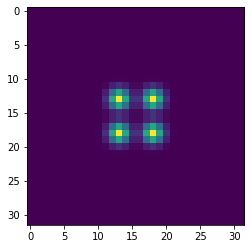

In [26]:
plt.imshow(images[1].reshape(32, 32))

In [27]:
indices_training, images_training = cryosbi.preprocess(indices, images)

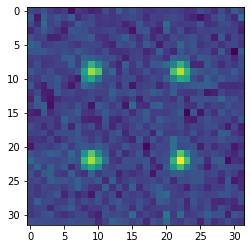

In [28]:
plt.imshow(images_training[350].reshape(32, 32))

In [3]:
posterior = cryosbi.train_posterior(1)

/Data/Packages/Research/miniconda3/envs/sbi_cryoem/lib/python3.8/site-packages/sbi/neural_nets/flow.py:108: UserWarning: In one-dimensional output space, this flow is limited to Gaussians
  warn(f"In one-dimensional output space, this flow is limited to Gaussians")


Neural network successfully converged after 34 epochs.


In [4]:
import pickle

with open("posterior_10_4.pkl", "rb") as handle:
    posterior = pickle.load(handle)

In [5]:
n_samples = 10000
samples = torch.zeros(20, n_samples, 1)

for i in range(20):
    true_index = torch.tensor([[0.0 + i]])
    true_image = cryosbi.simulator_analysis(true_index)
    samples[i] = posterior.sample((n_samples,), x=true_image, show_progress_bars=False)  

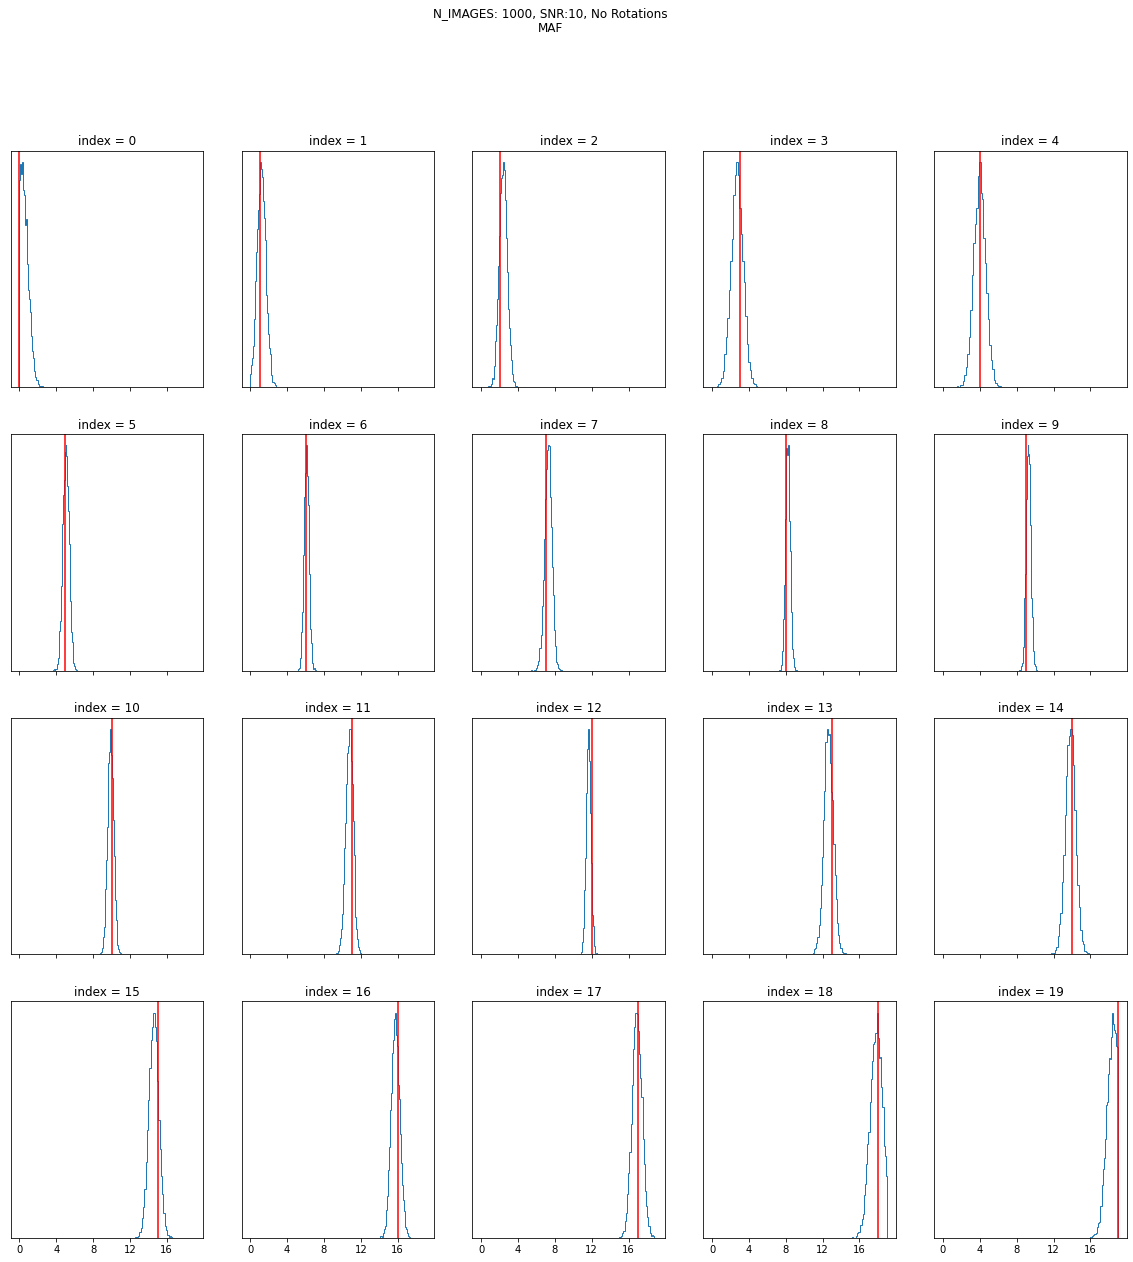

In [6]:
fig, axes = plt.subplots(4, 5, figsize=(20, 20), sharex=True)
fig.suptitle(f"N_IMAGES: {cryosbi.config['SIMULATION']['N_SIMULATIONS']}, SNR:{cryosbi.config['PREPROCESSING']['SNR']}, No Rotations\nMAF")

for i in range(4):
    for j in range(5):

        axes[i,j].hist(samples[i*5 + j].numpy().flatten(), bins=30, histtype="step")
        axes[i,j].axvline(x=i*5 + j, color="red")
        axes[i,j].set_title(f"index = {i*5 + j}")
        axes[i,j].set_yticks([])
        axes[i,j].set_xticks(range(0, 19, 4))